# BASE

In [1]:
import time
start1 = time.time()
from demo2_utils import *
from crowning2_utils import *
from crown_utils import *
from typing import Optional, Tuple
import matplotlib.pyplot as plt

def gen_crown1(zip_order_path, toothlib_scale=1):
    print(f'Run: gen_crown1')
    my_crown = None
    mesh_prep_fname, mesh_prep_3m = load_prep_from_zip(zip_order_path)
    mesh_big, mesh_small = get_two_largest_meshes_3m(mesh_prep_3m)
    my_case_details = get_toothnum(zip_order_path)
    tooth_filepath = os.path.join(tooth_dirpath_ottawa, f"{my_case_details[1]}.stl")
    tooth_mesh = pv.read(tooth_filepath)
    largest_plane = get_largest_axis_idx(mesh_prep_3m.bounds)
    if largest_plane in [0,2]:
        if largest_plane == 2:
            tooth_mesh1 = get_horizontal_position(mesh_prep_3m.bounds, mesh_small.centroid, tooth_mesh)
        elif largest_plane == 0:
            tooth_mesh1 = get_vertical_position(mesh_prep_3m.bounds, mesh_small.centroid, tooth_mesh)
        tooth_mesh2 = tooth_mesh1.scale(np.full(3, toothlib_scale))
        tooth_mesh3 = tooth_mesh2.translate(gen_move_coords(mesh_small.centroid, tooth_mesh2.center))
        my_crown = tooth_mesh3.boolean_difference(pv.wrap(mesh_small)).fill_holes(5)
    else:
        print('y-plane largest')
    return my_crown

def plot_crown(gen_crown, zip_order_path):
    mesh_prep_fname, mesh_prep_3m = load_prep_from_zip(zip_order_path)
    mesh_big, mesh_small = get_two_largest_meshes_3m(mesh_prep_3m)
    my_case_details = get_toothnum(zip_order_path)
    cam_pos = 'xy'
    my_shape = (1,2)
    p1_ = pv.Plotter(shape=my_shape)
    p1_.subplot(0,0) #1st plot
    p1_.add_mesh(mesh_small)
    p1_.add_mesh(mesh_big)
    p1_.add_mesh(my_crown, color='w')#, opacity=.7)
    p1_.add_text(f'{my_case_details[0]}', position='lower_right', font_size=10)
    p1_.camera_position=cam_pos
    p1_.show_grid()
    p1_.subplot(0,1) #2nd plot
    p1_.add_mesh(my_crown, color='gold')
    p1_.add_text(f'{my_case_details[1]}', position='upper_right')
    # p1_.add_text('antagonist', position='lower_right', font_size=10)
    p1_.camera_position=cam_pos
    p1_.show()


def matplot_pts(my_pts):
    grid_size = 1
    spogrid_size: int = 1
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax = fig.add_subplot(grid_size, grid_size, 1 + j + i * grid_size, projection="3d")
            c = my_pts
    
            if grid_size > 1:
                theta = np.pi * 2 * (i * grid_size + j) / (grid_size**2)
                rotation = np.array(
                    [
                        [np.cos(theta), -np.sin(theta), 0.0],
                        [np.sin(theta), np.cos(theta), 0.0],
                        [0.0, 0.0, 1.0],
                    ]
                )
                c = c @ rotation
    
            ax.scatter(c[:, 0], c[:, 1], c[:, 2])


def plot_point_cloud(
    # pc: PointCloud,
    pc: np.ndarray,
    color: bool = False,
    grid_size: int = 1,
    fixed_bounds: Optional[Tuple[Tuple[float, float, float], Tuple[float, float, float]]] = (
        (-0.75, -0.75, -0.75),
        (0.75, 0.75, 0.75),
    ),
):
    """
    Render a point cloud as a plot to the given image path.

    :param pc: the PointCloud to plot.
    :param image_path: the path to save the image, with a file extension.
    :param color: if True, show the RGB colors from the point cloud.
    :param grid_size: the number of random rotations to render.
    """
    fig = plt.figure(figsize=(8, 8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax = fig.add_subplot(grid_size, grid_size, 1 + j + i * grid_size, projection="3d")
            color_args = {}
            if color:
                color_args["c"] = np.stack(
                    [pc.channels["R"], pc.channels["G"], pc.channels["B"]], axis=-1
                )
            # c = pc.coords
            c = pc

            if grid_size > 1:
                theta = np.pi * 2 * (i * grid_size + j) / (grid_size**2)
                rotation = np.array(
                    [
                        [np.cos(theta), -np.sin(theta), 0.0],
                        [np.sin(theta), np.cos(theta), 0.0],
                        [0.0, 0.0, 1.0],
                    ]
                )
                # c = c @ rotation

            ax.scatter(c[:, 0], c[:, 1], c[:, 2], **color_args)

            if fixed_bounds is None:
                min_point = c.min(0)
                max_point = c.max(0)
                size = (max_point - min_point).max() / 2
                center = (min_point + max_point) / 2
                ax.set_xlim3d(center[0] - size, center[0] + size)
                ax.set_ylim3d(center[1] - size, center[1] + size)
                ax.set_zlim3d(center[2] - size, center[2] + size)
            else:
                ax.set_xlim3d(fixed_bounds[0][0], fixed_bounds[1][0])
                ax.set_ylim3d(fixed_bounds[0][1], fixed_bounds[1][1])
                ax.set_zlim3d(fixed_bounds[0][2], fixed_bounds[1][2])

    return fig
print(int(time.time()-start1),'s')

1 s


In [ ]:
my_scale = 1.1
my_crown = gen_crown1(my_orderpath, my_scale)
plot_crown(my_crown, my_orderpath)

# PROCESS (AFTER CROWN INITIAL POS)
1. extract margin edges
2. get the margin lowest y-coordinate
3. filter the generated crown using the margin lowest y-coordinate as threshold

# WORKSPACE

In [117]:
# case particular
tooth30_idx_ls = [8, 16, 26, 31, 34, 39, 43, 44, 58, 69, 86, 92, 94, 108, 117, 148, 150, 154, 157, 158, 169, 170, 180, 181, 183, 186, 192, 196, 221, 225, 250, 266]
my_idx = 0
my_orderpath = os.path.join(udx_dirpath, os.listdir(udx_dirpath)[tooth30_idx_ls[my_idx]])
my_orderpath

'/Users/nimbyx/Projects/CROWNING/cases/20230905113915481_2749854_W434.zip'

In [3]:
start = time.time()
mesh_prep_fname, mesh_prep_3m = load_prep_from_zip(my_orderpath)
mesh_big, mesh_small = get_two_largest_meshes_3m(mesh_prep_3m)
mesh_anta_fname, mesh_anta_3m = load_anta_from_zip(my_orderpath)
my_case_details = get_toothnum(my_orderpath)
print(f'{int(time.time()-start)}s')

0s


In [4]:
# get margin
prep_edges = pv.wrap(mesh_small).extract_feature_edges(10)
largest_edge = prep_edges.extract_largest().split_bodies()[0]

In [5]:
import vedo

# convert the extract margin to vedo points
margin_pts_ve = vedo.Points(largest_edge.points)
print(f'Before: {len(margin_pts_ve.points())} pts')
# downsample margin points break!
margin_pts2_ve = margin_pts_ve.subsample(0.04)
print(f'After: {len(margin_pts2_ve.points())} pts')

Before: 1257 pts
After: 50 pts


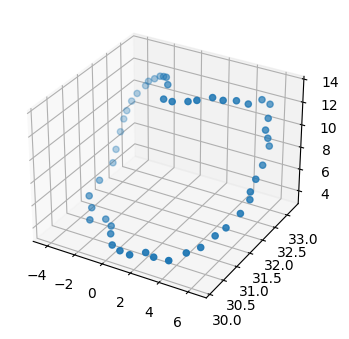

In [6]:
# interconnect the downsampled margin points
from scipy.spatial import KDTree

def continuous_line_from_pointcloud(pc):
    pc_copy = pc.copy()   
    start_point = pc_copy[np.random.choice(len(pc_copy))]
    current_point = start_point    
    lines = pv.PolyData()    
    while len(pc_copy) > 0:        
        distances = np.linalg.norm(pc_copy - current_point, axis=1)        
        nearest_i = np.argmin(distances)
        nearest_point = pc_copy[nearest_i]        
        lines += pv.Line(current_point, nearest_point)        
        pc_copy = np.delete(pc_copy, nearest_i, axis=0)        
        current_point = nearest_point    
    lines += pv.Line(current_point, start_point)
    return lines

margin_line = continuous_line_from_pointcloud(margin_pts2_ve.points())
matplot_pts(margin_line.points)

In [7]:
# margin cube 2
x_len2 = abs(margin_line.bounds[0] - margin_line.bounds[1])
y_len2 = abs(margin_line.bounds[2] - margin_line.bounds[3])
z_len2 = abs(margin_line.bounds[4] - margin_line.bounds[5])
my_cube2 = pv.Cube(center=mesh_small.centroid,
                    x_length=x_len2,
                    y_length=y_len2,
                    z_length=z_len2
                 )

In [54]:
# get antagonist intersect
mesh_anta_pv = pv.wrap(mesh_anta_3m)
start_pt = mesh_small.centroid
end_pt = mesh_small.centroid + np.array([0, 20, 0])
anta_line = pv.Line(start_pt, end_pt)
anta_intx= mesh_anta_pv.ray_trace(start_pt, end_pt)[0].flatten()
anta_slice = mesh_anta_pv.slice(normal=[1,0,0], origin=anta_intx)
anta_slice_min_y = anta_slice.points[np.argmin(anta_slice.points[:, 1])]


# get intersect of prep
mesh_prep_pv = pv.wrap(mesh_prep_3m)
mesh_intx = mesh_prep_pv.ray_trace(start_pt, end_pt)[0].flatten()
mesh_anta_surfs = pv.Line(mesh_intx, anta_intx)

# get mid point of the line bet anta and prep
mesh_anta_midpt = np.array((anta_intx + mesh_intx)/2)
end_pt2 = mesh_anta_midpt + np.array([10, 0 ,0])
end_pt3 = mesh_anta_midpt + np.array([-10, 0 ,0])
adj_line1 = pv.Line(mesh_anta_midpt, end_pt2)
adj_line2 = pv.Line(mesh_anta_midpt, end_pt3)

# get adjacent tooth distances
adj_intx1 = mesh_prep_pv.ray_trace(mesh_anta_midpt, end_pt2)[0].flatten()
adj_intx2 = mesh_prep_pv.ray_trace(mesh_anta_midpt, end_pt3)[0].flatten()
adj_dist = np.linalg.norm(adj_intx1 - adj_intx2)

In [43]:
line_len

array([0.7192402, 3.5474248, 0.8126794], dtype=float32)

In [28]:
# margin cube 3
# x_len3 = abs(margin_line.bounds[0] - margin_line.bounds[1])
y_len3 = abs(anta_intx[1] - margin_line.bounds[3]) # Using antagonist intersect
y_len3 = abs(margin_line.bounds[3] - margin_line.bounds[2])
z_len3 = abs(margin_line.bounds[5] - margin_line.bounds[4])

my_cube3 = pv.Cube(center=margin_line.center + np.array([0, (y_len3/2 + y_len2/2), 0]),
                    x_length=x_len3,
                    y_length=y_len3,
                    z_length=z_len3
                 )
# combine both cubes
my_cube4 = my_cube2 + my_cube3

(-4.704641819000244, 7.029688835144043, 30.554964065551758, 36.38062286376953, 2.6879208087921143, 13.960806846618652)
Lowest points on slice: [ 1.23626292 35.30057299  5.54376714]


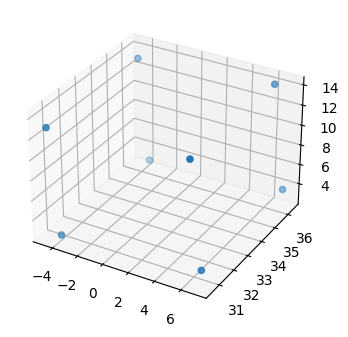

In [69]:
# create 1 cube from the combined cubes
# x_len5 = abs(my_cube4.bounds[1] - my_cube4.bounds[0])
offset_val = 0
center_offset = np.array([0, 0, offset_val])
new_center = my_cube4.center - center_offset

x_len5 = abs(my_cube4.bounds[1] - my_cube4.bounds[0])
y_len5 = abs(my_cube4.bounds[3] - my_cube4.bounds[2])
z_len5 = abs(my_cube4.bounds[5] - my_cube4.bounds[4]) 

my_cube5 = pv.Cube(
                    # center=my_cube4.center,
                    center=new_center,
                    # x_length=adj_dist
                    x_length=x_len5,
                    y_length=y_len5,
                    z_length=z_len5
                )

my_cube5 = my_cube5.rotate_y(-5, point=my_cube5.center) # adj teeth alignment (manual)

matplot_pts(my_cube5.points)
print(my_cube5.bounds)
print(f'Lowest points on slice: {anta_slice_min_y}')

In [116]:
# plot 2check cubes
tooth_desi = get_designer_tooth(my_orderpath)
my_plane = pv.Plane(center=anta_intx, i_size=15, j_size=15, direction=[0,1,0], j_resolution=15)
margin_extruded = margin_line.extrude_trim(direction=[0,1,0], trim_surface=my_plane)

p1 = pv.Plotter()

p1.add_mesh(margin_line, line_width=5, color='r')
p1.add_mesh(mesh_small, opacity=.8)

p1.add_points(margin_line.points, render_points_as_spheres=True, color='y', point_size=7)


# p1.add_mesh(tooth_mesh6_bool, color='w', opacity=.8)#, line_width=5, color='pink', opacity=.8)

p1.add_mesh(tooth_mesh6_bool2_FIX, opacity=.8, color='w')

p1.camera_position='zx'
p1.show_grid()
p1.show()

Widget(value="<iframe src='http://localhost:61469/index.html?ui=P_0x3d17b3be0_59&reconnect=auto' style='width:…

In [77]:
tooth_filepath = os.path.join(tooth_dirpath_ottawa, f"{my_case_details[1]}.stl")
tooth_mesh = pv.read(tooth_filepath)

largest_plane = get_largest_axis_idx(mesh_prep_3m.bounds)
if largest_plane in [0,2]:
    if largest_plane == 2:
        tooth_mesh1 = get_horizontal_position(mesh_prep_3m.bounds, mesh_small.centroid, tooth_mesh)
    elif largest_plane == 0:
        tooth_mesh1 = get_vertical_position(mesh_prep_3m.bounds, mesh_small.centroid, tooth_mesh)
    # tooth_mesh1 = tooth_mesh.rotate_y(90, point=tooth_mesh.center).rotate_x(-15, point=tooth_mesh.center).rotate_x(-compute_angle2(mesh_small)) # EXCEPTION
    tooth_mesh1 = tooth_mesh.rotate_y(85, point=tooth_mesh.center).rotate_z(-5, point=tooth_mesh.center)  # EXCEPTION PREPROCESS
    tooth_mesh2 = tooth_mesh1.scale(np.full(3, 1))

# tooth_mesh3 = tooth_mesh2.translate(gen_move_coords(mesh_small.centroid + np.array([-0.1,0,-0.5]), tooth_mesh2.center))

get vert pos
LOWER


In [78]:
# 1st boolean
toothmesh6_ve = Mesh(tooth_mesh2)
# my_cube5_ve = Mesh(my_cube5.rotate_x(-compute_angle2(mesh_small), point=my_margin.center))
my_cube5_ve = Mesh(my_cube5) # NO PREPROCESS (ROTATION)
tooth_mesh6_a = toothmesh6_ve.align_to_bounding_box(my_cube5_ve)
tooth_mesh6_a_3m = vedo_to_trimesh(tooth_mesh6_a)
mesh_small_pv = pv.wrap(mesh_small)
tooth_mesh6_a_pv = pv.wrap(tooth_mesh6_a_3m).rotate_x(-compute_angle2(mesh_small), point=tooth_mesh6_a_3m.centroid)

tooth_mesh6_bool = tooth_mesh6_a_pv.boolean_difference(mesh_small_pv, progress_bar=True)
tooth_mesh6_bool1 = tooth_mesh6_bool.scale(np.full(3, 1.0))#
tooth_mesh6_bool2 = tooth_mesh6_bool1.translate(np.subtract(tooth_mesh6_a_3m.centroid, tooth_mesh6_bool1.center))
tooth_mesh6_bool2.save('tooth_mesh6_bool2.stl') # save into a file to preserve quality before loading to vedo

Performing Boolean Operation: 100%|████████████████████████████████[00:01<00:00]


In [107]:
tooth_mesh6_bool_edges = tooth_mesh6_bool.extract_feature_edges(500).extract_largest().split_bodies()[0].extract_surface()

<Mesh(0x107f13e90) at 0x2872e6280>
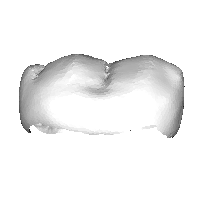

In [19]:
tooth_mesh6_bool2_ve = Mesh('tooth_mesh6_bool2.stl').c('w')
tooth_mesh6_bool2_ve

In [110]:
import pymeshfix

pymeshfix.clean_from_file('tooth_mesh6_bool2.stl', 'tooth_mesh6_bool2_FIX.stl')

In [112]:
tooth_mesh6_bool2_FIX = pv.read('tooth_mesh6_bool2_FIX.stl')

In [ ]:
# using align_to to align result crown bottom edges to margin

# get points included on warp
filter_value = 9.9 # this is the threshold line of the crown that separates the moving points from the whole mesh
srcs = []
trgts = []
tooth_mesh6_bool2_ve = Mesh(tooth_mesh6_bool2).c('w')
meshdec = tooth_mesh6_bool2_ve.clone().triangulate().decimate(n=200)

for pt in meshdec.points():
    if pt[2] > filter_value:
        srcs.append(pt)
        trgts.append(pt)

# collect the margin pts that are within the filter value
trgts2 = []
for pt2 in margin_line.points:
    if pt2[2] > filter_value:
        trgts2.append(pt2)

def find_closest_point(target_point, coordinates_array):
    target_point = np.array(target_point)
    coordinates_array = np.array(coordinates_array)
    distances = np.linalg.norm(coordinates_array - target_point, axis=1)
    closest_index = np.argmin(distances)
    closest_point = coordinates_array[closest_index]
    return closest_point

pt_reference = trgts2[10] #sample point ref from the target
# pt_reference = np.array([2,35,13.5]) #random

# get the ref point from source
closest_pt = find_closest_point(pt_reference, srcs)

srcs.append(closest_pt)
trgts.append(pt_reference)

result_edges_raw = tooth_mesh6_bool2.extract_feature_edges(120)
result_edge_ve = Mesh(vedo.Points(pv.PolyData(result_edges_raw.extract_largest().split_bodies()[0].points)).subsample(0.04))
result_edge_ve, 

In [ ]:
tooth_mesh6_bool2_ve

In [ ]:
start=time.time()
srcs1 = list(vedo.Points(srcs).subsample(0.04).points())

trgts1 = []
for pt_ in srcs1:
    trgts1.append(pt_)

trgts1.insert(0, pt_reference)
srcs1.insert(0, closest_pt)

print(len(srcs1))
print(len(trgts1))
print(int(time.time()-start),'s')

In [ ]:
# create vectors of sources
def compute_vectors(mesh):
    origin = tooth_mesh6_bool2.center
    vectors = mesh.points - origin
    vectors = vectors / np.linalg.norm(vectors, axis=1)[:, None]
    return vectors

src_mesh_pv = pv.PolyData(np.array(srcs))
src_vectors = compute_vectors(src_mesh_pv)
src_mesh_pv['vectors'] = src_vectors

# geom = pv.Arrow()
arrows = src_mesh_pv.glyph(
    orient='vectors',
    scale=False,
    factor=0.8,
    # geom=geom
)

In [ ]:
start_index = 24
increment = 31
num_points = 5  # Adjust this to the number of points you want

selected_points = []

for i in range(len(arrows.points)):
    index = start_index + i * increment
    if index < len(arrows.points):
        selected_points.append(arrows.points[index])

In [ ]:
px = pv.Plotter()
# px.add_mesh(mesh_prep_3m)
px.add_mesh(tooth_mesh6_bool2, color='w', opacity=.8)
# px.add_mesh(arrows, color='lightblue', opacity=.1)
px.add_mesh(margin_line.tube(radius=.1), color='r')

# px.add_points(np.array(trgts2), color='gold', point_size=15, render_points_as_spheres=True)
# px.add_points(np.array(src_mesh_ve.points()), color='maroon', point_size=5, render_points_as_spheres=True)
# px.add_points(np.array(arrows.points[24]), color='cyan', point_size=10, render_points_as_spheres=True)
# px.add_points(np.array(arrows.points[55]), color='cyan', point_size=10, render_points_as_spheres=True)
# px.add_points(np.array(selected_points), color='cyan', point_size=10, render_points_as_spheres=True)

px.show_grid()
px.camera_position='zx'
px.show()

In [ ]:
start=time.time()
warp = tooth_mesh6_bool2_ve.clone().warp(np.array(src_mesh_ve.points()), np.array(selected_points))
# warp.c("blue", 0.3).wireframe()
warp_3m = vedo_to_trimesh(warp)
print(int(time.time()-start),'s')

In [ ]:
def find_farthest_coordinate(coordinates_array):
    """
    Find the coordinate that is farthest from the centroid of the input array.

    Parameters:
    - coordinates_array: 2D NumPy array where each row is a 3D coordinate.

    Returns:
    - farthest_coordinate: 1D NumPy array representing the farthest coordinate.
    """
    # Ensure NumPy array for efficient calculations
    coordinates_array = np.array(coordinates_array)

    # Calculate the centroid of the coordinates
    centroid = np.mean(coordinates_array, axis=0)

    # Calculate the Euclidean distances from the centroid to all coordinates
    distances = np.linalg.norm(coordinates_array - centroid, axis=1)

    # Find the index of the maximum distance
    farthest_index = np.argmax(distances)

    # Get the farthest coordinate
    farthest_coordinate = coordinates_array[farthest_index]

    return farthest_coordinate



In [ ]:
src_mesh_ve = Mesh(src_mesh_pv)
src_mesh_ve

In [ ]:
scaled_pts = []

for i,pt in enumerate(src_mesh_ve.points()):
    new_pt = pt * src_mesh_pv['vectors'][i]
    scaled_pts.append(new_pt)

In [ ]:
# using align_to to align result crown bottom edges to margin
tooth_mesh6_bool2_ve = Mesh(tooth_mesh6_bool2)
result_edges_raw = tooth_mesh6_bool2.extract_feature_edges(120)
result_edge = result_edges_raw.extract_largest().split_bodies()[0]
result_edges_ve = vedo.Points(result_edge.points).subsample(0.04)

# print(len(result_edges_ve.points()))
# print(len(margin_pts2_ve.points()))
result_edge_mesh_ve = Mesh(result_edge)
margin_mesh_ve = Mesh(margin_pts2_ve)

srcs = [closest_pt]
# trgts = [trgts2[10]]
for pt in tooth_mesh6_bool2.points:
    if pt[2] > 9.9:
        srcs.append(pt)
        trgts.append(pt)

trgts2 = []
for pt2 in margin_line.points:
    if pt2[2] > 9.9:
        trgts2.append(pt2)
# align_result = result_edge_mesh_ve.clone().align_to(margin_mesh_ve, rigid=True).c("green5").lw(5)
warp = tooth_mesh6_bool2_ve.clone().warp(srcs, trgts)
warp.c("blue", 0.3).wireframe()
warp_3m = vedo_to_trimesh(warp)

px = pv.Plotter()
# px.add_mesh(
#     tooth_mesh6_bool2,
#     color='w'
# )
# px.add_points(
#     np.array(srcs),
#     point_size=5,
#     render_points_as_spheres=True,
#     color='r'
# )
px.add_points(
    np.array(trgts2),
    point_size=15,
    render_points_as_spheres=True,
    color='gold'
)

# px.add_points(
#     np.array(trgts2[10]),
#     point_size=15,
#     render_points_as_spheres=True,
#     color='red'
# )

# px.add_points(
#     np.array(closest_pt),
#     point_size=15,
#     render_points_as_spheres=True,
#     color='green'
# )
px.add_mesh(warp_3m)
px.show_grid()
px.show()

In [ ]:
def find_closest_point(target_point, coordinates_array):
    # Ensure NumPy arrays for efficient calculations
    target_point = np.array(target_point)
    coordinates_array = np.array(coordinates_array)

    # Calculate the Euclidean distances between the target point and all coordinates
    distances = np.linalg.norm(coordinates_array - target_point, axis=1)

    # Find the index of the minimum distance
    closest_index = np.argmin(distances)

    # Get the closest point
    closest_point = coordinates_array[closest_index]

    return closest_point

srcs = []
trgts = []
for pt in tooth_mesh6_bool2.points:
    if pt[2] > 9.9:
        srcs.append(pt)
        trgts.append(pt)
        
closest_pt = find_closest_point(trgts2[9], srcs)

srcs.append(closest_pt)
trgts.append(trgts2[9])

In [ ]:
warp = tooth_mesh6_bool2_ve.clone().warp(srcs, trgts)
warp.c("blue", 0.3).wireframe()
warp_3m = vedo_to_trimesh(warp)

In [ ]:
px = pv.Plotter()
px.add_mesh(
    tooth_mesh6_bool2,
    color='w'
)
px.add_points(
    np.array(srcs),
    point_size=5,
    render_points_as_spheres=True,
    color='r'
)
px.add_points(
    np.array(trgts2),
    point_size=15,
    render_points_as_spheres=True,
    color='gold'
)

px.add_points(
    np.array(trgts2[9]),
    point_size=15,
    render_points_as_spheres=True,
    color='red'
)

px.add_points(
    np.array(closest_pt),
    point_size=15,
    render_points_as_spheres=True,
    color='green'
)
# px.add_mesh(warp_3m)
px.show_grid()
px.show()

In [ ]:
"""Warp a region of a mesh using Thin Plate Splines.
Red points stay fixed while a single point in space
moves as the arrow indicates."""
from vedo import *

settings.use_depth_peeling = True
mesh = Mesh(dataurl+"man.vtk").color('w')

# a heavily decimated copy with about 200 points
meshdec = mesh.clone().triangulate().decimate(n=200)

sources = [[0.9, 0.0, 0.2]]  # this point moves
targets = [[1.2, 0.0, 0.4]]  # ...to this.
for pt in meshdec.points():
    if pt[0] < 0.3:          # these pts don't move
        sources.append(pt)   # (e.i. source = target)
        targets.append(pt)
arrow = Arrows(sources, targets)
apts = Points(sources).c("red")

warp = mesh.clone().warp(sources, targets)
warp.c("blue", 0.3).wireframe()

sphere = Sphere(r=0.3).pos(1,0,-.50)
sphere.apply_transform(warp.transform)
# print(warp.transform)

In [ ]:
# check first process plot
p2 = pv.Plotter()
p2.add_mesh(mesh_prep_3m)
p2.add_mesh(tooth_mesh6_a_3m, color='w')
p2.show_grid()
p2.camera_position='zx'
p2.show()

In [ ]:
tooth_mesh6_a_pv = pv.wrap(tooth_mesh6_a_3m).rotate_x(-compute_angle2(mesh_small), point=tooth_mesh6_a_3m.centroid)
margin_line_extuded = margin_line.extrude()
p3 = pv.Plotter()
p3.add_mesh(mesh_prep_3m)
p3.add_mesh(tooth_mesh6_a_pv, color='w')
p3.show_grid()
p3.camera_position='zx'
p3.show()

In [ ]:
# boolean
result_crown = pv.wrap(tooth_mesh6_a_3m).boolean_difference(pv.wrap(mesh_small), progress_bar=True)

In [ ]:
# reposition processed crown using center-center



In [ ]:
# plot 2check cubes
tooth_desi = get_designer_tooth(my_orderpath)
p2 = pv.Plotter()
p2.add_mesh(mesh_anta_surfs, line_width=5, color='r', point_size=5, render_points_as_spheres=True)
p2.add_mesh(my_cube5, 
            style='wireframe',
            opacity=.8,
            line_width=5, color='lightgreen')

p2.add_mesh(adj_line1, line_width=5, color='blue')
p2.add_mesh(adj_line2, line_width=5, color='blue')
p2.add_mesh(mesh_small)
# p2.add_mesh(mesh_anta_3m)
p2.add_mesh(result_crown,color='w')
# p2.add_mesh(mesh_small , opacity=.5)
# p2.add_mesh(tooth_mesh6_a_3m, color='w', opacity=.5)

p2.camera_position='zx'
p2.show_grid()
p2.show()

In [ ]:
bool1 = pv.read('bool1.stl')
bool1.boolean_difference('')

In [ ]:
bool1_ve = Mesh(bool1)
margin_mesh_ve = Mesh(margin_line.delaunay_2d())
bool2 = bool1_ve.cut_with_mesh(margin_mesh_ve)
bool2`

In [ ]:
pv.wrap(vedo_to_trimesh(bool2)).plot()

In [ ]:
p3 = pv.Plotter()
p3.add_mesh(tooth_mesh6_bool.split_bodies()[0].extract_surface().fill_holes(1), color='w')
p3.add_points(np.array(margin_pts_dsamp.points()), point_size=10, color='r', render_points_as_spheres=True)
p3.add_mesh(margin_line)

p3.camera_position='zx'
p3.show()

In [ ]:
tooth_mesh6_bool2 = tooth_mesh6_bool.split_bodies()[0].extract_surface().fill_holes(5)
tooth_mesh6_bool2.extract_feature_edges(200).plot()

In [ ]:
tooth_mesh6_bool.split_bodies()[0].extract_surface().fill_holes(1).n_faces/3

In [ ]:
v = np.array(tooth_mesh6_bool.split_bodies()[0].extract_surface().points)
f = np.array(tooth_mesh6_bool.split_bodies()[0].extract_surface().faces)

# Ensure that the length of f is a multiple of 3
remainder = len(f) % 3
if remainder != 0:
    # Truncate or pad f to make it a multiple of 3
    f = f[:len(f) - remainder]

# Calculate the number of faces based on the length of f
n_faces = len(f) // 3
f_reshaped = f.reshape((n_faces, 3))
meshfix = pymeshfix.MeshFix(v, f_reshaped)

In [ ]:
meshfix.repair()

In [ ]:
import pymeshfix
v = tooth_mesh6_bool.split_bodies()[0].extract_surface().fill_holes(1).points[:-1]
f = tooth_mesh6_bool.split_bodies()[0].extract_surface().fill_holes(1).faces
n_faces = int(len(v)/3)
f_reshaped = f.reshape((n_faces, 3))
meshfix = pymeshfix.MeshFix(v, f)

# Plot input
meshfix.plot()

In [ ]:
tooth_desi = get_designer_tooth(my_orderpath)
tooth_desi.save('tooth_desi.stl')

In [ ]:
tooth_desi = get_designer_tooth(my_orderpath)
height_offset = 0.75
tooth_mesh4 = tooth_mesh3.scale(np.full(3, 1.15))
# tooth_mesh5 = tooth_mesh4.translate(gen_move_coords(mesh_small.centroid + np.array([-.20, 0, -0.45]), tooth_mesh4.center))
tooth_mesh5 = tooth_mesh4.translate(gen_move_coords(mesh_small.centroid, tooth_mesh4.center))
tooth_mesh6 = tooth_mesh5.scale(np.full(3, 1.001))
# tooth_mesh6 = tooth_mesh6.translate(gen_move_coords(mesh_small.centroid + np.array([-.08, 0, -0.55]), tooth_mesh6.center))
tooth_mesh6 = tooth_mesh6.translate(gen_move_coords(mesh_small.centroid, tooth_mesh6.center))

In [ ]:
tooth_filepath = os.path.join(tooth_dirpath_ottawa, f"{my_case_details[1]}.stl")
tooth_mesh = pv.read(tooth_filepath)
test_crown = tooth_mesh.rotate_y(90, point=tooth_mesh.center).rotate_x(-compute_angle2(mesh_small), point=tooth_mesh.center).translate(gen_move_coords(mesh_small.centroid, tooth_mesh.center))

In [ ]:
# Create a circular shape (e.g., a circle)
theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
z = np.zeros_like(theta)

# Create a PolyData object from the circle
circle = pv.PolyData(np.column_stack((x, y, z)))
marg_pts = pv.PolyData(margin_pts2_ve.points())
# Create a surface mesh from the circle
surface_mesh = circle.extrude([0, 0, 1])
marg_mesh = marg_pts.extrude([0,1,0])
# Create a tube around the surface mesh
# tube = surface_mesh.tube(radius=0.1, capping=True)
marg_tubed = marg_mesh.tube(radius=0.8, capping=True)

# Plot the result
p0=pv.Plotter()

p0.add_mesh(marg_tubed)
p0.add_mesh(tooth_mesh8, color='w')
p0.add_points(marg_pts, color='r', point_size=10, render_points_as_spheres=True)
p0.show()


In [ ]:
import pyvista as pv
import numpy as np

# Create a circular shape (e.g., a circle)
theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
z = np.zeros_like(theta)

# Create a PolyData object from the circle
circle = pv.PolyData(np.column_stack((x, y, z)))

# Create a surface mesh from the circle
surface_mesh = circle.extrude([0, 0, 1])

# Create a tube around the surface mesh
tube = surface_mesh.tube(radius=0.1, capping=False)

# Plot the result
p0 = pv.Plotter()
p0.add_points(tube.points, color='r', render_points_as_spheres=True, point_size=3)
p0.show()


In [ ]:
margin_line.tube(radius=0.1).plot()

In [ ]:
def interpolate_line(point1, point2, num_points=100):
    # Linearly interpolate between the two points
    t = np.linspace(0, 1, num_points)
    interpolated_points = (1 - t)[:, np.newaxis] * point1 + t[:, np.newaxis] * point2
    return interpolated_points

interpolated_line = interpolate_linev

In [ ]:
import numpy as np
import pyvista

n = 1000
theta = np.linspace(-10 * np.pi, 10 * np.pi, n)
z = np.linspace(-2, 2, n)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
points = np.column_stack((x, y, z))

# Create line connectivity
lines = np.column_stack((range(n - 1), range(1, n)))

pdata = pyvista.PolyData(points)
pdata.lines = lines
pdata['distance'] = range(n)
ribbon = pdata.ribbon(width=0.2)
ribbon.plot(show_scalar_bar=False)


In [ ]:
import trimesh

my_meshes = []
extrude_3m = trimesh.load('tooth_extrude.stl', file='stl')
my_meshes.append(extrude_3m)
my_meshes.append(mesh_small)

In [ ]:
result = trimesh.boolean.difference(my_meshes)

In [ ]:
def extrude(polyline):
    return polyline.ribbon(normal=(0,0,1))


p = pv.Plotter(notebook=False)

def extrude_and_show(polyline):
    surface = extrude(polyline)
    p.add_mesh(surface, color="pink", name="mysurf")

p.add_spline_widget(extrude_and_show)
p.show_axes()
p.show()

In [ ]:
import pymeshfix as mf

meshfix = mf.MeshFix()

In [ ]:
start = time.time()
result_3m = vedo_to_trimesh(result_ve)
result_pv = pv.wrap(result_3m).translate(gen_move_coords(my_cube5.center, result_3m.centroid))
result2_pv = result_pv.boolean_difference(pv.wrap(mesh_small)).fill_holes(5)
print(int(time.time()-start),'s')

In [ ]:
margin_pts_dsamp_mesh = pv.PolyData(margin_pts_dsamp.points()).delaunay_2d()
margin_pts_dsamp_mesh.plot(show_grid=True, cpos='iso')

In [ ]:
tp = pv.Plotter()
tp.add_mesh(test2)
tp.add_mesh(margin_pts_dsamp_mesh, color='r')
tp.show_grid()
tp.camera_position='zx'
tp.show()

In [ ]:
plane = pv.Plane(center=(0, 0, 1), i_size=2, j_size=0.2, direction=[1, 1, 1], j_resolution=1)
line = pv.Line()
extruded_line = line.extrude_trim((0, 0, 1), plane)
pl = pv.Plotter()
pl.add_mesh(line, style='wireframe', line_width=20, show_scalar_bar=False, color='r')
pl.add_mesh(plane, 
            # style='wireframe', 
            color='black', 
            show_scalar_bar=False)
pl.add_mesh(extruded_line, show_scalar_bar=False, lighting=False)
pl.show()

In [ ]:
base_edge = pv.wrap(mesh_small).extract_feature_edges(90)

In [ ]:
point2 = np.array(margin_mesh_pv.center)
point1 = np.array(base_edge.center)
np.linalg.norm(point1 - point2)

In [ ]:
# tooth libr
my_case_details = get_toothnum(my_orderpath)
tooth_filepath = os.path.join(tooth_dirpath_ottawa, f"{my_case_details[1]}.stl")
tooth_mesh = pv.read(tooth_filepath)
largest_plane = get_largest_axis_idx(mesh_prep_3m.bounds)
if largest_plane in [0,2]:
    if largest_plane == 2:
        tooth_mesh1 = get_horizontal_position(mesh_prep_3m.bounds, margin_mesh_pv.center, tooth_mesh)
    elif largest_plane == 0:
        tooth_mesh1 = get_vertical_position(mesh_prep_3m.bounds, margin_mesh_pv.center, tooth_mesh)
    tooth_mesh2 = tooth_mesh1.scale(np.full(3, 1))
    tooth_mesh3 = tooth_mesh2.translate(gen_move_coords(margin_mesh_pv.center, tooth_mesh2.center))

In [ ]:
np.full(3, 1.12)

In [ ]:
tooth_mesh4 = tooth_mesh3.scale(np.full(3, 1.15)).translate(gen_move_coords(margin_mesh_pv.center, tooth_mesh3.center))

In [ ]:
tooth_mesh4 =tooth_mesh4.translate(gen_move_coords(margin_mesh_pv.center, tooth_mesh4.center))

In [ ]:
col, n_contacts = margin_mesh_pv.collision(tooth_mesh3)
collision_mask = np.zeros(margin_mesh_pv.n_cells, dtype=bool)
collision_mask[col["ContactCells"]] = True
margin_mesh_pv["collisions"] = collision_mask

In [ ]:
col1, n_contacts1 = tooth_mesh3.collision(margin_mesh_pv)
collision_mask1 = np.zeros(tooth_mesh3.n_cells, dtype=bool)
collision_mask1[col1["ContactCells"]] = True
tooth_mesh3["collisions"] = collision_mask1

In [ ]:
tooth_mesh3.plot(opacity=.8)

In [ ]:
test_npy = np.load('/Users/nimbyx/Downloads/splines.npy', allow_pickle=True)
type(test_npy)

In [ ]:
limb = Mesh(dataurl + "270.vtk").c("gold")
rim = Mesh(dataurl + "270_rim.vtk").c("red5").lw(4)

limb

In [ ]:
rim

In [ ]:
rim2 = rim.clone().align_to(limb, rigid=True).c("green5").lw(5)
rim2

In [ ]:
d = 0
for p in rim2.points():
    cpt = limb.closest_point(p)
    d += mag2(p - cpt)  # square of residual distance
average_squared_distance = d / rim2.npoints

# Print the average squared distance between the aligned rim and the limb
printc("Average squared distance =", average_squared_distance, c="g")

show(limb, rim, rim2, __doc__, axes=1)

In [ ]:
show(cube, viewup='z')

In [ ]:
show(msh1, axes2, viewup='z')

In [ ]:
np.array(msh1.faces())

In [ ]:
# Create a triangle.
disc = pv.Disc(c_res=3, r_res=4, inner=0)
plane = pv.Plane(
    center=(disc.center[0], disc.center[1], -1),
    direction=(0, 0, -1),
    i_size=1,
    j_size=1,
)

# extrude with and without the all_edges option
extruded_disc = disc.extrude_trim((0, 0, -1.0), plane)
extruded_disc_all = disc.extrude_trim((0, 0, -1.0), plane, extrusion='all_edges')
print(f'Extrusion has {extruded_disc.n_faces} faces with default boundary_edges')
print(f'Extrusion has {extruded_disc_all.n_faces} faces with all_edges')
pl = pv.Plotter(shape=(1, 2))
pl.add_mesh(extruded_disc, style='wireframe', line_width=5)
pl.add_text('Extrude with boundary_edges')

pl.subplot(0, 1)
pl.add_mesh(extruded_disc_all, style='wireframe', line_width=5)
pl.add_text('Extrude with all_edges')

pl.link_views()
pl.camera_position = 'iso'
pl.camera.zoom(1.3)
pl.show()

In [ ]:
pv.PolyData(pv.read('/Users/nimbyx/Downloads/mesh.ply').points).plot()

In [ ]:
"""Align 2 shapes:
the red line to the yellow surface"""
from vedo import *

# Load two mesh objects, a limb and a rim, and color them gold and red
limb = Mesh(dataurl + "270.vtk").c("gold")
rim = Mesh(dataurl + "270_rim.vtk").c("red5").lw(4)

# Make a clone copy of the rim and align it to the limb
# Using rigid=True does not allow scaling
rim2 = rim.clone().align_to(limb, rigid=True).c("green5").lw(5)

# Calculate the average squared distance between the aligned rim and the limb
d = 0
for p in rim2.points():
    cpt = limb.closest_point(p)
    d += mag2(p - cpt)  # square of residual distance
average_squared_distance = d / rim2.npoints

# Print the average squared distance between the aligned rim and the limb
printc("Average squared distance =", average_squared_distance, c="g")

# show(limb, rim, rim2, __doc__, axes=1)
show(rim, axes=1)

In [ ]:
test_mesh = vedo_to_trimesh(limb)
test_mesh2 = vedo_to_trimesh(rim)
test_mesh3 = vedo_to_trimesh(rim2)
p1 = pv.Plotter()
# p1.add_mesh(test_mesh)
p1.add_points(test_mesh2.vertices, point_size=10, color='r')
p1.add_points(test_mesh3.vertices, point_size=10, color='green')
p1.show_grid()
p1.show()